# Q2

## Import libraries

In [1]:
import torch
import os
import torchvision
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import seaborn as sns
from timeit import default_timer as timer
import torch.hub
!pip install timm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.2 MB/s eta 0:00:00


## DataLoader

### Preprocessong

In [2]:
mean, std = 0.5, 0.5

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((mean, mean, mean), (std, std, std))
])

In [3]:
train_dataset_CIFAR10 = torchvision.datasets.CIFAR10(
    root = "data", # where to download data to
    train = True, # get training data
    download = True, # download data if it doesn't exist on disk
    transform = transform # images come as PIL format, we want to turn into Torch tensors
)

test_dataset_CIFAR10 = torchvision.datasets.CIFAR10(
    root = "data",
    train = False, # get test data
    download = True,
    transform = transform
)

100%|██████████| 170498071/170498071 [00:01<00:00, 91424715.41it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
def create_dataloader(train_dataset, test_dataset, batch_size):
  train_dataloader = DataLoader(
      dataset = train_dataset,
      batch_size = batch_size,
      num_workers = 2,
      shuffle = True
  )

  test_dataloader = DataLoader(
      dataset = test_dataset,
      batch_size = batch_size,
      num_workers = 2,
      shuffle = False
  )
  return train_dataloader, test_dataloader

In [5]:
batch_size = 32
train_dataloader_CIFAR10, test_dataloader_CIFAR10 = create_dataloader(
    train_dataset_CIFAR10, test_dataset_CIFAR10, batch_size)

### Show one sample CIFAR-10 dataset

In [6]:
def show_sample(train_dataloader, mean, std):
  # Check out what's inside the training dataloader
  train_features_batch, train_labels_batch = next(iter(train_dataloader))
  print("train_features_batch.shape = " + str(train_features_batch.shape) +
        ", train_labels_batch.shape = " + str(train_labels_batch.shape))
  img, label = train_features_batch[0], train_labels_batch[0]
  img = std * img + mean
  plt.imshow(img.permute(1, 2, 0), cmap='gray')
  plt.axis("Off");
  print(f"Image size: {img.shape}")
  print(f"Label: {label}")

train_features_batch.shape = torch.Size([32, 3, 224, 224]), train_labels_batch.shape = torch.Size([32])
Image size: torch.Size([3, 224, 224])
Label: 7


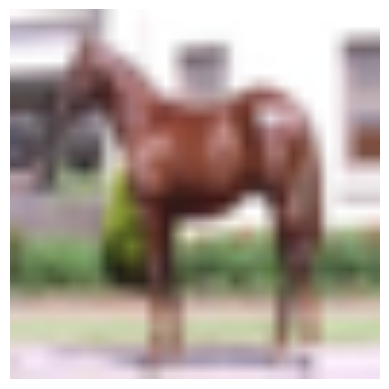

In [7]:
# CIFAR10 sample
show_sample(train_dataloader_CIFAR10, mean, std)

## Prerequisite functions to fit and validate model

### Define needed function to fit models

In [8]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device):
    
    # Send model to GPU
    model.to(device)
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += accuracy_fn(true=y.cpu(),
                                     pred=y_pred.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss.item()/counter, refresh=True)

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

        # Calculate loss and accuracy per epoch and print out what's happening
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)
        
    return train_loss.item(), train_acc

In [9]:
def test_step(model,
              data_loader,
              loss_fn,
              accuracy_fn,
              device):
    
    # Send model to GPU
    model.to(device)

    # put model in eval mode
    model.eval() 
    test_loss, test_acc, counter = 0, 0, 0
    with torch.no_grad():
        with tqdm(data_loader, desc ="   test") as test_tqdm:
            for X, y in test_tqdm:
                # Send data to GPU
                X, y = X.to(device), y.to(device)

                # 1. Forward pass
                test_pred = model(X)

                # 2. Calculate loss and accuracy
                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(true=y.cpu(),
                                        pred=test_pred.cpu())
                counter += 1
                test_tqdm.set_postfix(test_acc=test_acc/counter, test_loss=test_loss.item()/counter, refresh=True)

            # Adjust metrics and print out
            test_loss /= len(data_loader)
            test_acc  /= len(data_loader)

    return test_loss.item(), test_acc

In [10]:
def accuracy_fn(true, pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 5)

In [12]:
def optimizer(model):
  learning_rate = 0.0001
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  return optimizer

In [11]:
def fit(model, train_dataloader, test_dataloader, optimizer, epochs, lr_scheduler, loss_fn, device):
  train_epoch_loss = []
  train_epoch_accuracy = []
  test_epoch_loss = []
  test_epoch_accuracy = []

  train_time_start = timer()

  for epoch in range(epochs):
      print("EPOCH {}/{} :".format(epoch +1, epochs))
      train_loss, train_acc = train_step(data_loader=train_dataloader,
                                                model=model, 
                                                loss_fn=loss_fn,
                                                optimizer=optimizer,
                                                accuracy_fn=accuracy_fn,
                                                device=device
                                                )
      test_loss, test_acc = test_step(data_loader=test_dataloader,
                                      model=model,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn,
                                      device=device
                                      )

      train_epoch_loss.append(train_loss)
      train_epoch_accuracy.append(train_acc)
      test_epoch_loss.append(test_loss)
      test_epoch_accuracy.append(test_acc)

      # Update learning rate based on test accuracy
      lr_scheduler.step(test_acc)

  train_time_end = timer()
  total_time = train_time_end - train_time_start
  print(f"\n\nTrain time: {total_time:.5f} seconds")
  return train_epoch_loss, test_epoch_loss, train_epoch_accuracy, test_epoch_accuracy

### Define function to plot accurary and loss figures

In [13]:
def accloss_plots(train_loss, test_loss, train_acc, test_acc):
  
    num_epochs = len(train_loss)
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(train_loss, 'r', label='Train')
    plt.plot(test_loss , 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=25, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.subplot(122)
    plt.plot(train_acc, 'r', label='Train')
    plt.plot(test_acc, 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=25, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.show();

## Models

### DeiTBaseDistilled

In [ ]:
# Define number of classes from each dataset
num_classes_CIFAR10 = len(train_dataset_CIFAR10.classes)

# Define the Transformer model
transformer_model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

transformer_model.head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(transformer_model.head.in_features, 256),
    nn.ELU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, num_classes_CIFAR10)
)

# Unfreeze the 12th Transformer Block
for param in transformer_model.blocks[11].parameters():
    param.requires_grad = True

transformer_model

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth
100%|██████████| 330M/330M [00:03<00:00, 101MB/s]


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = optimizer(transformer_model)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=3,
                                 threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0.0000001, verbose=True)

In [ ]:
epochs_num = 5
train_loss1, test_loss1, train_acc1, test_acc1 = fit(
    transformer_model, train_dataloader_CIFAR10, test_dataloader_CIFAR10, optimizer, epochs_num, lr_scheduler, loss_fn, device)

EPOCH 1/5 :


   test: 100%|██████████| 313/313 [01:45<00:00,  2.96it/s, test_acc=96.1, test_loss=0.119]


EPOCH 2/5 :


   test: 100%|██████████| 313/313 [01:45<00:00,  2.96it/s, test_acc=96.2, test_loss=0.116]


EPOCH 3/5 :


   test: 100%|██████████| 313/313 [01:45<00:00,  2.96it/s, test_acc=96.1, test_loss=0.122]


EPOCH 4/5 :


   test: 100%|██████████| 313/313 [01:45<00:00,  2.96it/s, test_acc=94.8, test_loss=0.197]


EPOCH 5/5 :


   test: 100%|██████████| 313/313 [01:45<00:00,  2.96it/s, test_acc=96.1, test_loss=0.131]



Train time: 8501.83067 seconds


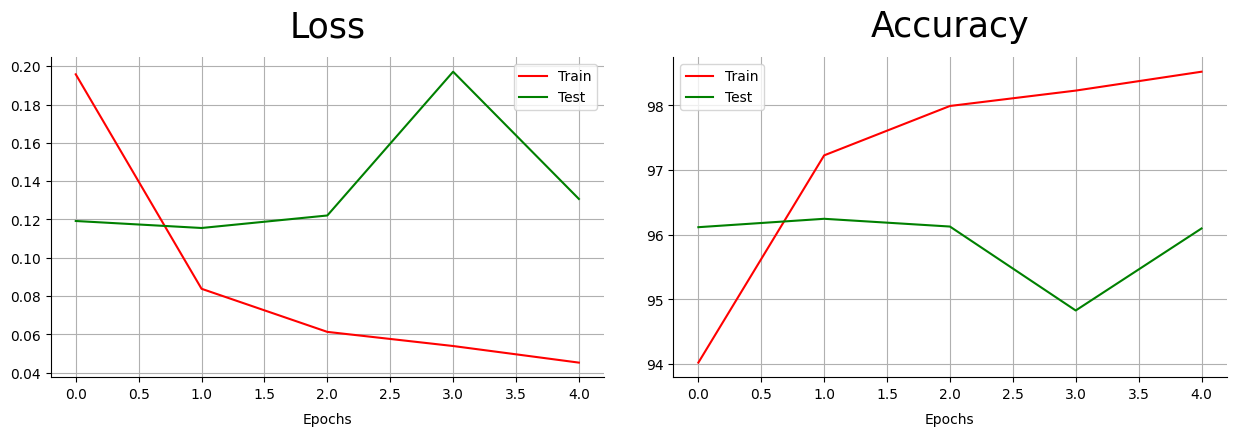

In [ ]:
accloss_plots(train_loss=train_loss1, 
                  test_loss=test_loss1, 
                  train_acc=train_acc1, 
                  test_acc=test_acc1)

## VGG19 with 20 epochs (correct)

In [14]:
# Define number of classes from each dataset
num_classes_CIFAR10 = len(train_dataset_CIFAR10.classes)

# Load VGG19 model
vgg19_3 = models.vgg19(pretrained=True)

# Freeze all layers except block5_conv1 
for param in vgg19_3.features.parameters():
    param.requires_grad = False
for param in vgg19_3.classifier.parameters():
    param.requires_grad = False
for param in vgg19_3.features[28].parameters(): # block5_conv1
    param.requires_grad = True
    
# Replace classifier with new one 
vgg19_3.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 256), # 25088 is output of block5_conv1
    nn.ELU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, num_classes_CIFAR10)
)

vgg19_3

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 267MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
loss_fn4 = nn.CrossEntropyLoss()
device4 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer4 = optimizer(vgg19_3)
lr_scheduler4 = ReduceLROnPlateau(optimizer4, mode='max', factor=0.6, patience=3,
                                 threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0.0000001, verbose=True)

In [16]:
epochs_num4 = 20
train_loss4, test_loss4, train_acc4, test_acc4 = fit(
    vgg19_3, train_dataloader_CIFAR10, test_dataloader_CIFAR10, optimizer4, epochs_num4, lr_scheduler4, loss_fn4, device4)

EPOCH 1/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.36it/s, test_acc=88.9, test_loss=0.334]


EPOCH 2/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.37it/s, test_acc=89.9, test_loss=0.292]


EPOCH 3/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.37it/s, test_acc=90.1, test_loss=0.305]


EPOCH 4/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.34it/s, test_acc=90.5, test_loss=0.323]


EPOCH 5/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.33it/s, test_acc=90.4, test_loss=0.338]


EPOCH 6/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.33it/s, test_acc=90.8, test_loss=0.355]


EPOCH 7/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.33it/s, test_acc=90.5, test_loss=0.385]


EPOCH 8/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.35it/s, test_acc=90.9, test_loss=0.37]


EPOCH 9/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.34it/s, test_acc=90.6, test_loss=0.437]


EPOCH 10/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.32it/s, test_acc=91.1, test_loss=0.389]


EPOCH 11/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.34it/s, test_acc=90.6, test_loss=0.482]


EPOCH 12/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.34it/s, test_acc=91.2, test_loss=0.437]


EPOCH 13/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.34it/s, test_acc=90.9, test_loss=0.466]


EPOCH 14/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.33it/s, test_acc=91.3, test_loss=0.454]


EPOCH 15/20 :


   test: 100%|██████████| 313/313 [00:59<00:00,  5.30it/s, test_acc=90.8, test_loss=0.508]


EPOCH 16/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.33it/s, test_acc=91, test_loss=0.485]


Epoch 00016: reducing learning rate of group 0 to 6.0000e-05.
EPOCH 17/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.33it/s, test_acc=91.7, test_loss=0.482]


EPOCH 18/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.32it/s, test_acc=91.8, test_loss=0.518]


EPOCH 19/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.33it/s, test_acc=91.7, test_loss=0.531]


EPOCH 20/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.33it/s, test_acc=91.2, test_loss=0.592]



Train time: 7294.60512 seconds


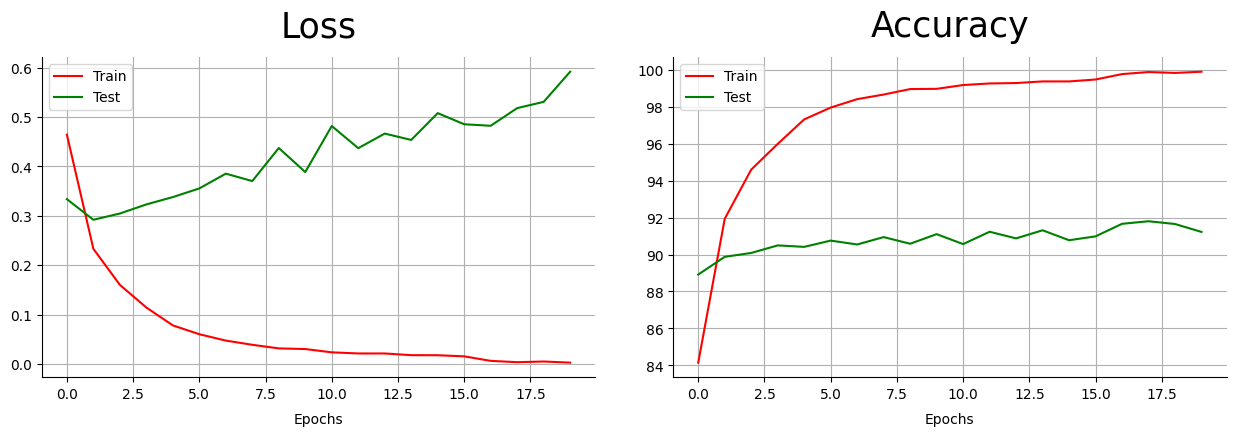

In [17]:
accloss_plots(train_loss=train_loss4, 
                  test_loss=test_loss4, 
                  train_acc=train_acc4, 
                  test_acc=test_acc4)

## VGG19 with 20 epochs (incorrect)

In [ ]:
# Define number of classes from each dataset
num_classes_CIFAR10 = len(train_dataset_CIFAR10.classes)

# Load VGG19 model
vgg19_2 = models.vgg19(pretrained=True)

# Freeze all layers except block5_conv1 
for pafram in vgg19_2.features.parameters():
    param.requires_grad = False
for param in vgg19_2.classifier.parameters():
    param.requires_grad = False
for param in vgg19_2.features[24].parameters(): # ReLU
    param.requires_grad = True
    
# Replace classifier with new one 
vgg19_2.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 256),
    nn.ELU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, num_classes_CIFAR10)
)

vgg19_2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 93.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
loss_fn3 = nn.CrossEntropyLoss()
device3 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer3 = optimizer(vgg19_2)
lr_scheduler3 = ReduceLROnPlateau(optimizer3, mode='max', factor=0.6, patience=3,
                                 threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0.0000001, verbose=True)

In [ ]:
epochs_num3 = 20
train_loss3, test_loss3, train_acc3, test_acc3 = fit(
    vgg19_2, train_dataloader_CIFAR10, test_dataloader_CIFAR10, optimizer3, epochs_num3, lr_scheduler3, loss_fn3, device3)

EPOCH 1/20 :


   test: 100%|██████████| 313/313 [01:00<00:00,  5.15it/s, test_acc=85, test_loss=0.433]


EPOCH 2/20 :


   test: 100%|██████████| 313/313 [01:01<00:00,  5.13it/s, test_acc=86.3, test_loss=0.404]


EPOCH 3/20 :


   test: 100%|██████████| 313/313 [01:01<00:00,  5.13it/s, test_acc=86, test_loss=0.405]


EPOCH 4/20 :


   test: 100%|██████████| 313/313 [01:01<00:00,  5.13it/s, test_acc=86.8, test_loss=0.402]


EPOCH 5/20 :


   test: 100%|██████████| 313/313 [01:00<00:00,  5.14it/s, test_acc=86.9, test_loss=0.415]


EPOCH 6/20 :


   test: 100%|██████████| 313/313 [01:00<00:00,  5.13it/s, test_acc=86.6, test_loss=0.45]


EPOCH 7/20 :


   test: 100%|██████████| 313/313 [01:00<00:00,  5.14it/s, test_acc=86.8, test_loss=0.465]


EPOCH 8/20 :


   test: 100%|██████████| 313/313 [01:00<00:00,  5.14it/s, test_acc=86.4, test_loss=0.492]


EPOCH 9/20 :


   test: 100%|██████████| 313/313 [01:00<00:00,  5.14it/s, test_acc=87.2, test_loss=0.483]


EPOCH 10/20 :


   test: 100%|██████████| 313/313 [01:00<00:00,  5.16it/s, test_acc=87.4, test_loss=0.524]


EPOCH 11/20 :


   test: 100%|██████████| 313/313 [01:01<00:00,  5.11it/s, test_acc=86.6, test_loss=0.563]


EPOCH 12/20 :


   test: 100%|██████████| 313/313 [01:01<00:00,  5.13it/s, test_acc=86.2, test_loss=0.608]


EPOCH 13/20 :


   test: 100%|██████████| 313/313 [01:01<00:00,  5.12it/s, test_acc=87, test_loss=0.622]


EPOCH 14/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.38it/s, test_acc=86.6, test_loss=0.663]


Epoch 00014: reducing learning rate of group 0 to 6.0000e-05.
EPOCH 15/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.35it/s, test_acc=86.9, test_loss=0.661]


EPOCH 16/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.37it/s, test_acc=87.2, test_loss=0.662]


EPOCH 17/20 :


   test: 100%|██████████| 313/313 [00:58<00:00,  5.37it/s, test_acc=87.3, test_loss=0.681]


EPOCH 18/20 :


   test: 100%|██████████| 313/313 [01:00<00:00,  5.15it/s, test_acc=87.6, test_loss=0.674]


EPOCH 19/20 :


   test: 100%|██████████| 313/313 [01:01<00:00,  5.11it/s, test_acc=87.5, test_loss=0.686]


EPOCH 20/20 :


   test: 100%|██████████| 313/313 [01:00<00:00,  5.16it/s, test_acc=87.1, test_loss=0.731]



Train time: 7290.27262 seconds


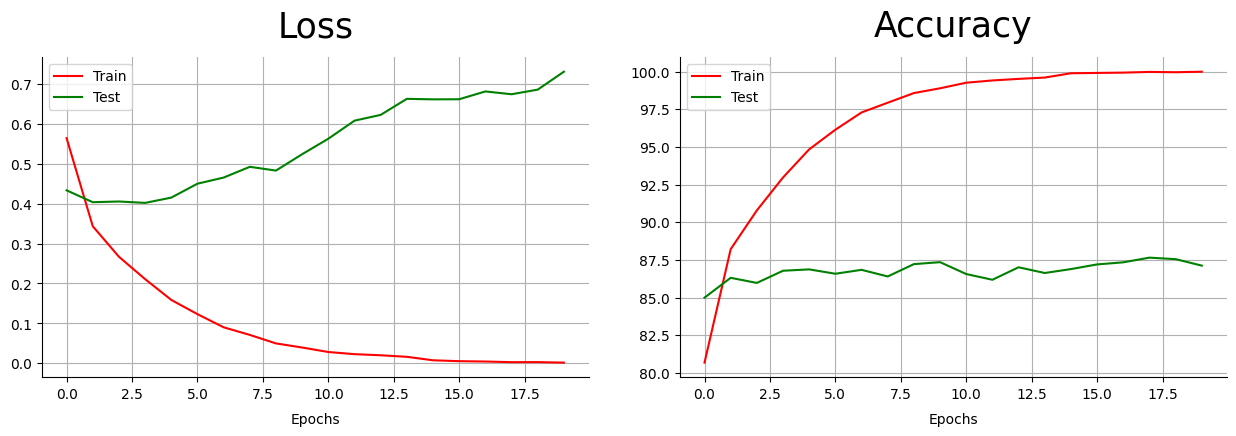

In [ ]:
accloss_plots(train_loss=train_loss3, 
                  test_loss=test_loss3, 
                  train_acc=train_acc3, 
                  test_acc=test_acc3)